<a href="https://colab.research.google.com/github/mhanauer/google_colab_test/blob/master/first_py_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
import streamlit as st
# To make things easier later, we're also importing numpy and pandas for
# working with sample data.
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [284]:
# import new data
from google.colab import files
uploaded = files.upload()
drop_out_dat = pd.read_csv("drop_out_8_10_20.csv", delimiter = ",", na_values = [-99, -98, -1, -2, -3, -4, -5, -6, -7, -8, -9])
drop_out_dat.head()

Saving drop_out_8_10_20.csv to drop_out_8_10_20 (3).csv


,Quarter,Gender,RaceWhite,RaceBlack,Agegroup,OverallHealth,CapableManagingHealthCareNeeds,HandlingDailyLife,ControlLife,DealWithCrisis,GetsAlongWithFamily,SocialSituations,FunctioningHousing,Symptoms,Nervous,Hopeless,Restless,Depressed,EverythingEffort,Worthless,PsychologicalEmotionalProblems,LifeQuality,EnoughEnergyForEverydayLife,PerformDailyActivitiesSatisfaction,HealthSatisfaction,RelationshipSatisfaction,SelfSatisfaction,Tobacco_Use,Alcohol_Use,Cannabis_Use,ViolenceTrauma,Housing,Education,Employment,EnoughMoneyForNeeds,Friendships,EnjoyPeople,BelongInCommunity,SupportFromFamily,SupportiveFamilyFriends,GenerallyAccomplishGoal,telehealth,grant,EverServed,ActiveDuty_Else,NightsHomeless,drop_out,aiety,mdd_r,mdd_s,another_s_ident,drug_use,er_hos_use_base,jail_arrest_base
0,2,1.0,0.0,1.0,8.0,4.0,3.0,2.0,3.0,2.0,3.0,2.0,4.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,2.0,NaN,4.0,4.0,1.0,2.0,1.0,1.0,12.0,0.0,4.0,4.0,2.0,4.0,3.0,3.0,4.0,0,0,0.0,2.0,0.0,0,NaN,NaN,NaN,0.0,9.0,0.0,0.0
1,1,0.0,1.0,0.0,6.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,4.0,5.0,4.0,5.0,3.0,4.0,2.0,1.0,1.0,1.0,0.0,13.0,1.0,2.0,5.0,4.0,4.0,4.0,4.0,4.0,0,0,0.0,0.0,12.0,0,NaN,NaN,NaN,1.0,12.0,0.0,0.0
2,1,0.0,1.0,0.0,8.0,2.0,1.0,2.0,4.0,4.0,1.0,5.0,1.0,2.0,4.0,4.0,4.0,3.0,3.0,4.0,5.0,2.0,4.0,5.0,5.0,NaN,NaN,4.0,1.0,1.0,1.0,0.0,14.0,0.0,3.0,2.0,4.0,4.0,2.0,5.0,5.0,0,0,0.0,0.0,26.0,0,NaN,NaN,NaN,0.0,9.0,4.0,2.0
3,1,1.0,1.0,0.0,7.0,4.0,2.0,2.0,2.0,4.0,1.0,4.0,1.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,4.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,1.0,0.0,14.0,0.0,1.0,3.0,2.0,1.0,2.0,2.0,4.0,0,0,0.0,2.0,30.0,0,NaN,NaN,NaN,0.0,9.0,0.0,0.0
4,2,0.0,0.0,1.0,7.0,2.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,14.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,0,0,0.0,2.0,0.0,0,NaN,NaN,NaN,0.0,12.0,0.0,0.0


In [285]:
y = drop_out_dat[["drop_out"]]
predictors = drop_out_dat.drop(["drop_out"], axis = 1)

In [286]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [287]:
y = y.values.ravel()
predictors_names = predictors
predictors = predictors.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size = .20, random_state = 53)

In [288]:
pipe = Pipeline([
    ("classifer", XGBClassifier())
])
params = dict(  
    classifer__max_depth=[6,12,15, 18],
    classifer__eta= [.01, .001, .3, .4, .5, .6, .7],
    classifer__colsample_bytree=[.3, .4,.5, .6, .7, .8, .9],
    classifer__subsample= [.5, .6, .7],
    classifer__lambda=[1, 1.1, 1.2, 1.3, 1.4],
    classifer__alpha= [0, .1, .2, .3]
    )
gs = RandomizedSearchCV(pipe, params, n_jobs=-1, cv = 10)  
gs.fit(X_train, y_train) 

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('classifer',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            gamma=0,
                                                            learning_rate=0.1,
                                                            max_delta_step=0,
                                                            max_depth=3,
                                                            min_child_weight=1,
                                                            missing=None,

In [289]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('classifer',
                 XGBClassifier(alpha=0.2, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, eta=0.001, gamma=0,
                               lambda=1.2, learning_rate=0.1, max_delta_step=0,
                               max_depth=18, min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.7,
                               verbosity=1))],
         verbose=False)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [385]:
best_model = XGBClassifier(params = gs.best_estimator_)  # and for classifier
best_model.fit(X_train, y_train)
# Run this model so you can feature importance
scoring = ['accuracy', 'precision', 'balanced_accuracy']
cv_results_best_model = cross_validate(best_model.fit(X_train, y_train) , X_train, y_train, cv=10, scoring=scoring)
#cv_results
cv_results_best_model
cv_results_best_model = pd.DataFrame(cv_results_best_model)
cv_results_best_model.round(2)

,fit_time,score_time,test_accuracy,test_precision,test_balanced_accuracy
0,0.18,0.01,0.79,0.81,0.63
1,0.18,0.00,0.78,1.00,0.60
2,0.17,0.00,0.83,0.95,0.70
3,0.18,0.00,0.74,0.67,0.54
4,0.17,0.00,0.80,0.93,0.64
5,0.17,0.00,0.76,0.86,0.56
6,0.17,0.00,0.77,0.77,0.60
7,0.18,0.00,0.79,1.00,0.61
8,0.18,0.00,0.79,1.00,0.61
9,0.17,0.00,0.82,0.94,0.67


In [ ]:
best_model

<bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              params={'alpha': [0.1], 'colsample_bytree': [0.7], 'eta': [0.5],
                      'lambda': [1.4], 'max_depth': [12], 'subsample': [0.7]},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)>

In [390]:
# Run this to get best model with reduced variables
# Select from model for trees using a imputirty based measure to select the measures
# Then refit the model, because you cannot use automatted functions with missing data
num_feats = X_train.shape[1]
from sklearn.feature_selection import SelectFromModel
embeded_lgb_selector = SelectFromModel(best_model, max_features=num_feats)
embeded_lgb_selector.fit(X_train, y_train)
embeded_lgb_support = embeded_lgb_selector.get_support()
## Get the column names 
col_preds =  pd.DataFrame(predictors_names.columns, columns = ["feature"])
col_preds
embeded_lgb_support = pd.DataFrame(embeded_lgb_support, columns = ["keep"])
frames = [col_preds, embeded_lgb_support]
test_combine = pd.concat(frames, axis=1)
test_combine = test_combine[test_combine["keep"] == True]
X_train_pd = pd.DataFrame(X_train)
X_train_pd.columns = [predictors_names.columns]
test_combine = test_combine["feature"].tolist()
test_combine
X_train_pd = X_train_pd[[test_combine]]
X_train_pd = X_train_pd.to_numpy()
type(X_train_pd)
best_model.fit(X_train_pd, y_train)
### Now update X_test
X_test_pd = pd.DataFrame(X_test)
X_test_pd.columns = [predictors_names.columns]
X_test_pd
X_test_pd = X_test_pd[[test_combine]]
X_test_pd = X_test_pd.to_numpy()

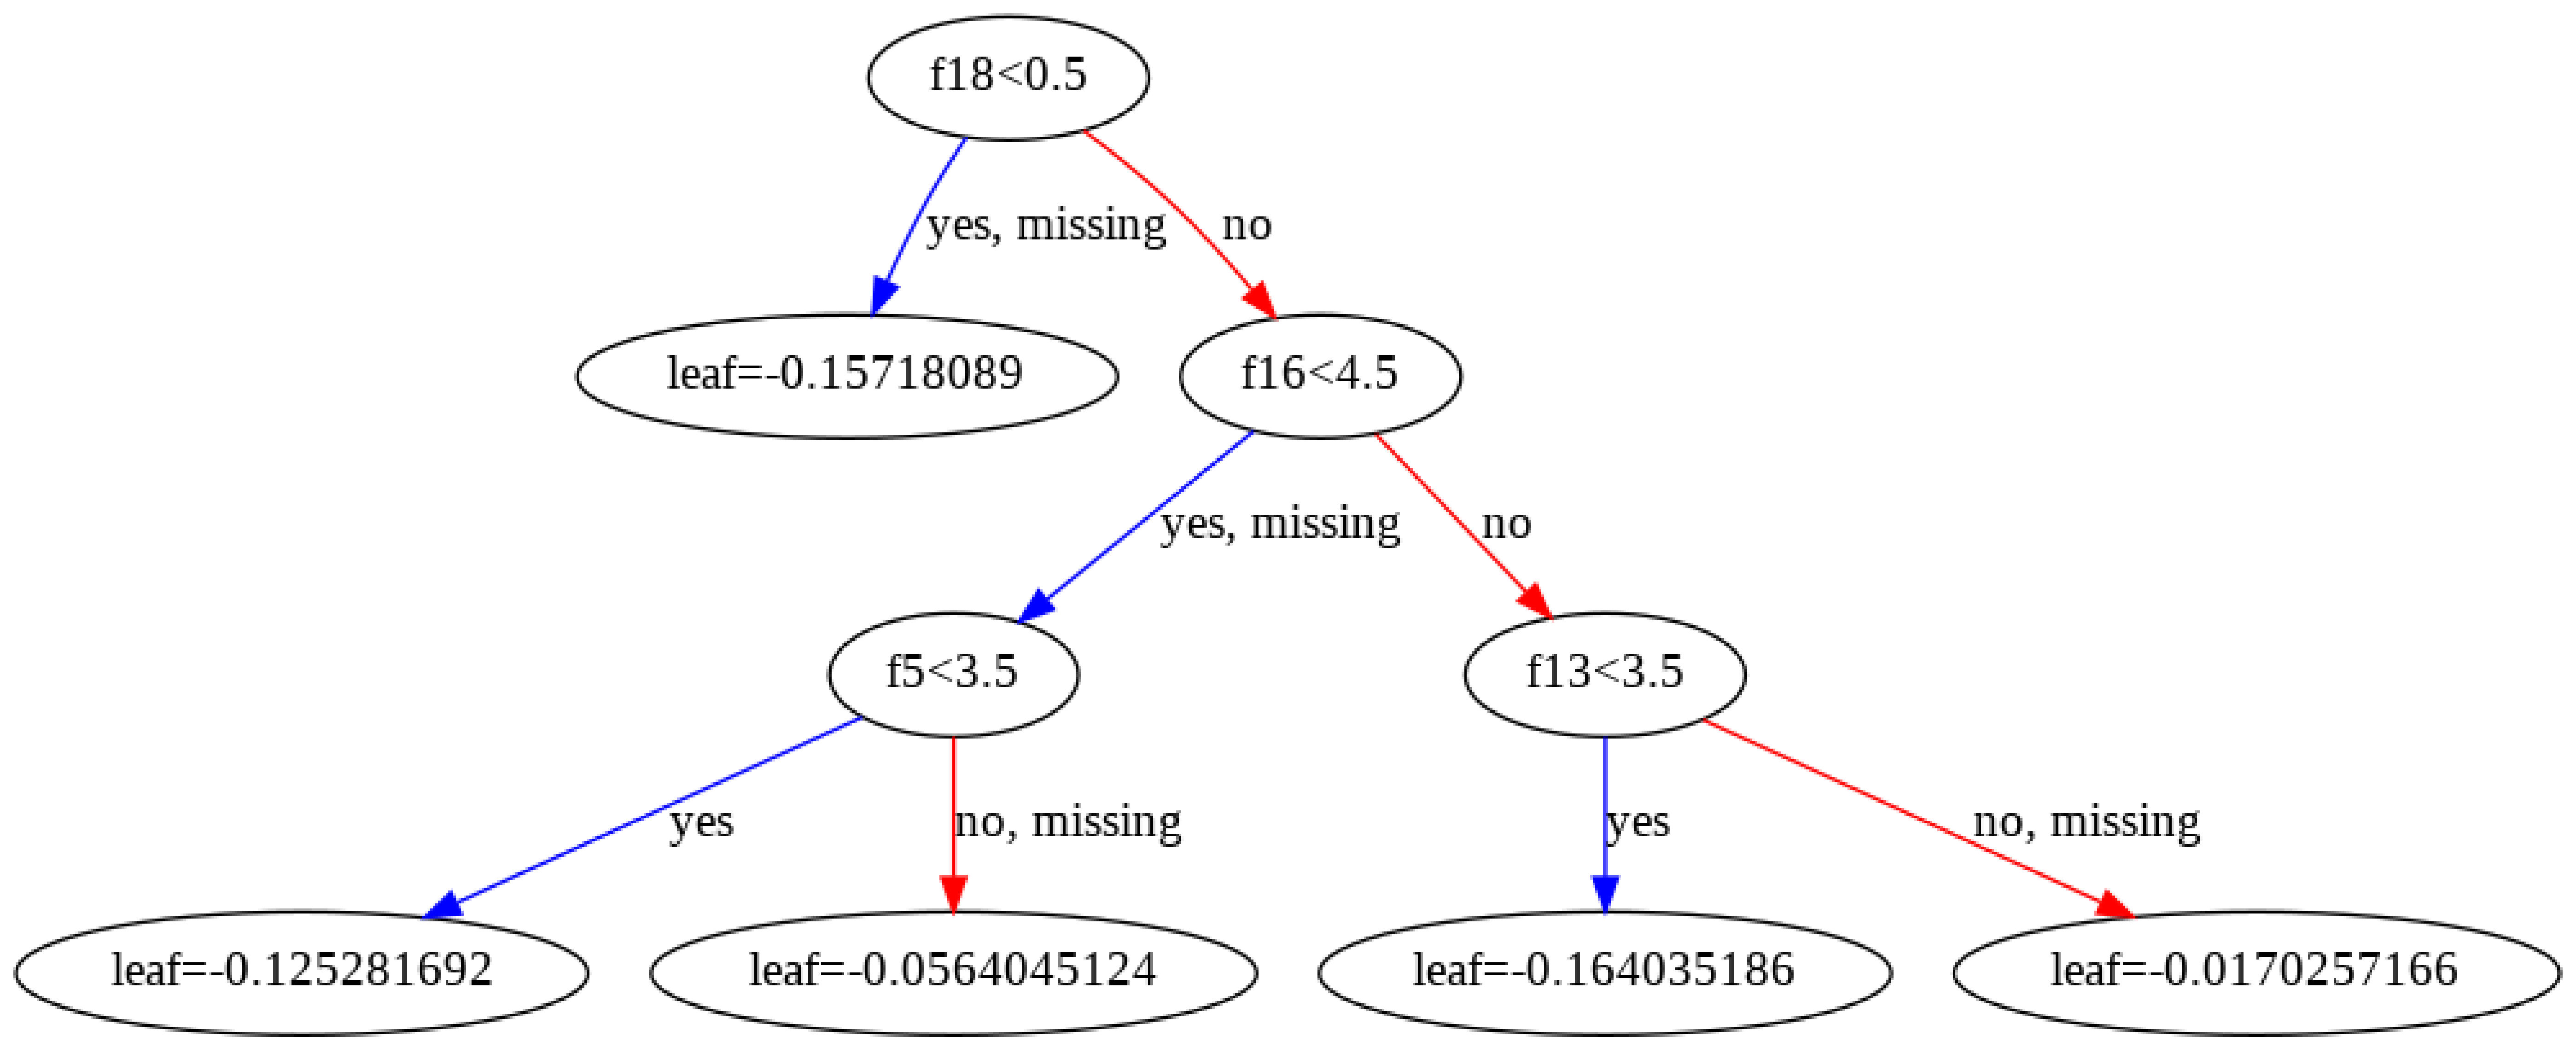

In [359]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from xgboost import plot_tree
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 100,80
tree_plot = plot_tree(best_model, num_trees = 1)
tree_plot

In [360]:
# Get feature importance
from xgboost import plot_importance
from xgboost import plot_tree
importance = best_model.get_booster().get_score(importance_type='gain')
importance = pd.DataFrame(data = importance, index= [0])
importance =  importance.round(2)
importance_t = importance.transpose()
importance_t = pd.DataFrame(importance_t)
importance_t["feature"] = importance_t.index
importance_t.columns = ["importance", "feature"]
#importance_t.shape
### Just get the top ten and rename those and sort by importance
importance_t = importance_t.sort_values(by= ["importance"], ascending=False)
importance_t_ten = importance_t.iloc[0:10]
importance_t_ten
importance_t_ten['feature'] = importance_t_ten['feature'].str.replace(r'\D', '')
var_names =  importance_t_ten["feature"].to_list()
importance_t_ten

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,importance,feature
f18,11.83,18
f15,6.28,15
f16,6.21,16
f17,5.69,17
f12,5.61,12
f13,5.20,13
f11,5.00,11
f2,4.58,2
f5,4.53,5
f14,4.42,14


In [361]:
importance_t_ten = importance_t_ten.reset_index(drop = True)
names = pd.DataFrame(predictors_names.columns, columns = ["feature_names"])
names = names.iloc[[18, 15, 16, 17, 12, 13, 11, 2, 5, 14],:]
names = pd.DataFrame(names)
names = names.reset_index(drop = True)
names
importance_t_ten
frames = [names, importance_t_ten]
frames
importance_t_ten = pd.concat(frames, axis = 1)
importance_t_ten

,feature_names,importance,feature
0,EverythingEffort,11.83,18
1,Hopeless,6.28,15
2,Restless,6.21,16
3,Depressed,5.69,17
4,FunctioningHousing,5.61,12
5,Symptoms,5.20,13
6,SocialSituations,5.00,11
7,RaceWhite,4.58,2
8,OverallHealth,4.53,5
9,Nervous,4.42,14


In [366]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [381]:
importance_t_ten.to_csv("/drive/My Drive/Colab Notebooks/importance_t_ten.csv")
test_combine = pd.DataFrame(test_combine, columns = ["features"])
test_combine
test_combine.to_csv("/drive/My Drive/Colab Notebooks/test_combine.csv")

In [ ]:
import plotly.express as px
fig = px.bar(importance_t_ten, x='importance', 
            y='features_name', 
            labels = {"importance": "Importance", "features_name": "Feature"},
            title = "Top 10 feature importance",
            text = "importance", 
            category_orders  = {"features_name": ["CCBHC", "PsychologicalEmotionalProblems", "SupportiveFamilyFriends", "ViolenceTrauma", "ViolenceTrauma", "OverallHealth", "Tobacco_Use", "NightsHomeless", "Friendships", "anxiety", "GetsAlongWithFamily"]})
fig


In [375]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
pred_auc = best_model.predict_proba(X_test_pd)
pred_auc =  pred_auc[:,1]
precision, recall, thresholds = precision_recall_curve( y_test, pred_auc)
# Find the thresholds that produces the maximum precision and recall
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
thresholds[ix]

Best Threshold=0.351478, F-Score=0.662


0.35147795

In [376]:
### Need to get the predicted probabilities
pred_prob =  best_model.predict_proba(X_test_pd)
prob_drop =   pd.DataFrame(pred_prob[:,1], columns = ["prob_drop"])
def if_else(row):

    if row['prob_drop'] >thresholds[ix]:

        val = 1
    
    else:

        val = 0

    return val

prob_drop = prob_drop.apply(if_else, axis=1)
prob_drop

### Get a confusion matrix and then get sensitivity by hand
con_mat = confusion_matrix(y_test, prob_drop)
#sensitivity <- TP / (TP + FN)
#specificity <- TN / (TN + FP)
con_mat
#tn, fp, fn, tp
sensitivity =  con_mat[1][1] / (con_mat[1][1] + con_mat[1][0])
specificity = con_mat[0][0] / (con_mat[0][0] + con_mat[0][1])
accuracy = (con_mat[1][1] + con_mat[0][0]) / (con_mat[1][1] + con_mat[1][0] + con_mat[0][0] + con_mat[0][1])
### 
balanced_accuracy =  (sensitivity+specificity)/2

sensitivity = pd.DataFrame(sensitivity, columns = ["sensitivity"], index = [0])
specificity = pd.DataFrame(specificity, columns = ["specificity"], index = [0])
accuracy = pd.DataFrame(accuracy, columns = ["accuracy"], index = [0 ])
balanced_accuracy = pd.DataFrame(balanced_accuracy, columns = ["balanced_accuracy"], index = [0])

frames = [sensitivity, specificity, balanced_accuracy, accuracy]
metrics_dat = pd.concat(frames, axis = 1)
metrics_dat = metrics_dat.round(2)
metrics_dat

,sensitivity,specificity,balanced_accuracy,accuracy
0,0.7,0.83,0.76,0.79


In [364]:
### Need to get the predicted probabilities
pred_prob =  gs.predict_proba(X_test)
prob_drop =   pd.DataFrame(pred_prob[:,1], columns = ["prob_drop"])
def if_else(row):

    if row['prob_drop'] > thresholds[ix]:

        val = "very high risk"

    elif row['prob_drop'] >thresholds[ix] / 2:

        val = "high risk "
    
    elif row['prob_drop'] > thresholds[ix] / 3:
        
        val = "medium risk"
    
    else:

        val = "low risk"

    return val

prob_drop['risk_level'] = prob_drop.apply(if_else, axis=1)
prob_drop['risk_level'].value_counts()
        

low risk          217
very high risk    128
high risk          54
medium risk        21
Name: risk_level, dtype: int64

In [392]:
def predict(input_df):
    predictions_df = best_model.predict_proba(input_df)
    prob_drop =   pd.DataFrame(predictions_df[:,1], columns = ["prob_drop"])
    return prob_drop
predict(X_test_pd)

,prob_drop
0,0.209771
1,0.784759
2,0.336871
3,0.102891
4,0.039395
...,...
415,0.376667
416,0.376667
417,0.046474
418,0.064754
